# A Tutorial on Generating a Synthetic Dataset for Computational Single Particle Imaging

The purpose of this tutorial is to generate a synthetic dataset of diffraction patterns and their associated orientations for computational Single Particle Imaging (cSPI). The tutorial first discusses general diffraction theory. The tutorial then introduces steps on installing Pysingfel, a Python-based SPI Simulation for Free-Electron Lasers. Using Pysingfel, the tutorial setups and simulates an SPI Experiment. Lastly, the diffraction patterns and orientations are collected from the SPI experiment to create the synthetic dataset.

## Diffraction Theory

<table><tr>
    <td> <b>Establishing the relation between the detector and reciprocal space</b><br>
From this geometry, the relationship between the
detector and the reciprocal space is given by 
$$q = \frac{2}{\lambda} \sin \theta$$
$$q_x = q(1 - \frac{\lambda^2 q^2}{4})^\frac{1}{2} \sin (\arctan2(x, y))$$
$$q_y = q(1 - \frac{\lambda^2 q^2}{4})^\frac{1}{2} \cos (\arctan2(x, y))$$
$$q_z = -\frac{\lambda}{2}q^2$$
$$\vec{q} = (q_x, q_y, q_z) = \vec{k}_{out} - \vec{k}_{in}$$
where $\vec{q}$ is the scattering vector, $\lambda$ is the wavelength, and $2\theta$ is the angle between the incident and scattered wave vector $k_{in}$ and $k_{out}$, respectively. The coordinates $(x, y)$ denote the position of the detector pixel, which has a corresponding point $(q_x, q_y, q_z)$ in reciprocal space located on the Ewald sphere.<br><br>
        <b>Determining the photon count for a pixel on the detector</b><br>
If $D$ is the particle diameter, $\Phi$ is the incident flux, $o$ is the oversampling ratio, and $r_e$ is the electron radius, then the expected photon count $n(q)$ for a pixel on the detector
can then be determined by
$$n(q) = \Phi r_e^2 |F(\vec{q})|^2\left(\frac{\lambda}{oD}\right)^2$$
for small scattering angles $2\theta$ where
$$F(\vec{q}) = \sum_{j=1}^N f_j(q) \exp (2 \pi i \vec{q} \cdot X_j')$$
and $X_j' = RX_j$ where $R$ here is the matrix that rotates the particle, represented by the three-dimensional atomic coordinates $X_j=\{(x_j, y_j, z_j)\}$, to a new position $X_j'=\{(x'_j,y'_j,z'_j)\}$.<br><br>
        <b>Shot noise</b><br>
Simulators often account for **shot noise** by assuming that the actual photon count $N$ follows Poisson statistics. 
$$N \sim \text{Poi}(n(q))$$<br><br>
Adapted from I. Poudyal, M. Schmidt, and P. Schwander, “Single-particle imaging by x-ray free-electron lasers—How many snapshots are needed?,” Structural Dynamics, 7(2):24102 (2020).
    </td>
<td> <img src="images/cspi_generate_synthetic_dataset_Fig1.png" style="width: 1400px;"/>  </td>
</tr></table>

## Gather dependencies for the SPI Simulation

To create the synthetic dataset, we will need to install Pysingfel and import the software dependencies needed to simulate an SPI Experiment and create the synthetic dataset.

The following instructions can be used to install Pysingfel on the SLAC PS login node.

```bash
ssh YOURACCOUNTNAME@pslogin.stanford.edu
git clone https://github.com/fredericpoitevin/pysingfel.git
source ~/.bashrc
cd pysingfel
python setup.py install --user
cd examples/input
wget https://stanford.box.com/s/e7c30tvhfz0485j2xr48rnrvel8a4yby -O lcls.zip
tar -xvf lcls.tar.gz
```

Then navigate to https://pswww.slac.stanford.edu/ in your browser and use JupyterHub to open this notebook from the ```examples``` directory

Once the notebook is open, we will then need to import Pysingfel along with other software dependencies needed to create the synthetic dataset:

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#import time
import os
import sys

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize

import h5py as h5

import pysingfel

import pysingfel as ps

## Simulate the SPI Experiment

We will simulate an SPI Experiment to create the synthetic dataset. To simulate the experiment, we will require the following:
- A PDB, in this case [3iyf](https://www.rcsb.org/structure/3IYF), a protein found in a bacteria
- The beam parameters of an AMO instrument
- The geometry parameters of a pnCCD detector

In this simulated experiment, a collection of two-dimensional diffraction patterns of 3iyf will be recorded by the pnCCD detector. These patterns are taken in random orientations [[1]](#[1]). The patterns and orientations will be used to create the synthetic dataset.

In [2]:
input_dir='../input'

# PDB
particle = ps.Particle()
pdbfile=input_dir+'/pdb/3iyf.pdb'
particle.read_pdb(pdbfile, ff='WK')

# Apply hydration layer
hydration_layer_thickness = 0.0 # 10.0 / 10**10
mesh_voxel_size           = 2.0 / 10**10
particle.set_hydration_layer_thickness(hydration_layer_thickness)
particle.set_mesh_voxel_size(mesh_voxel_size)
particle.get_masks()

# Beam parameters
beamfile=input_dir+'/beam/amo86615.beam'
beam = ps.Beam(beamfile)

# Geometry of detector
geom=input_dir+'/lcls/amo86615/PNCCD::CalibV1/Camp.0:pnCCD.1/geometry/0-end.data'
det = ps.PnccdDetector(geom=geom, beam=beam)

# Simulate the SPI Experiment
experiment = ps.SPIExperiment(det, beam, particle)

## Create the dataset from the simulated experiment

To create the synthetic dataset, we collect $100$ diffraction patterns and their respective orientations from the simulated experiment. 

In [3]:
dataset_size = 100

diffraction_pattern_height = det.detector_pixel_num_x.item()
diffraction_pattern_width = det.detector_pixel_num_y.item()

orientation_n_components = 4 # orientations are expressed as unit quaternions

diffraction_patterns = np.zeros((dataset_size, diffraction_pattern_height, diffraction_pattern_width))
orientations = np.zeros((dataset_size, orientation_n_components))

for data_index in range(dataset_size):
    diffraction_pattern, orientation = experiment.generate_image(return_orientation=True)
    diffraction_patterns[data_index] = diffraction_pattern
    orientations[data_index] = orientation

In [4]:
print("Shape of diffraction patterns dataset\t: {}".format(diffraction_patterns.shape))
print("Shape of orientations dataset\t\t: {}".format(orientations.shape))

Shape of diffraction patterns dataset	: (100, 1024, 1040)
Shape of orientations dataset		: (100, 4)


To get a better understanding of the dataset, we plot the diffraction patterns in $\log$ scale along with their respective orientations.

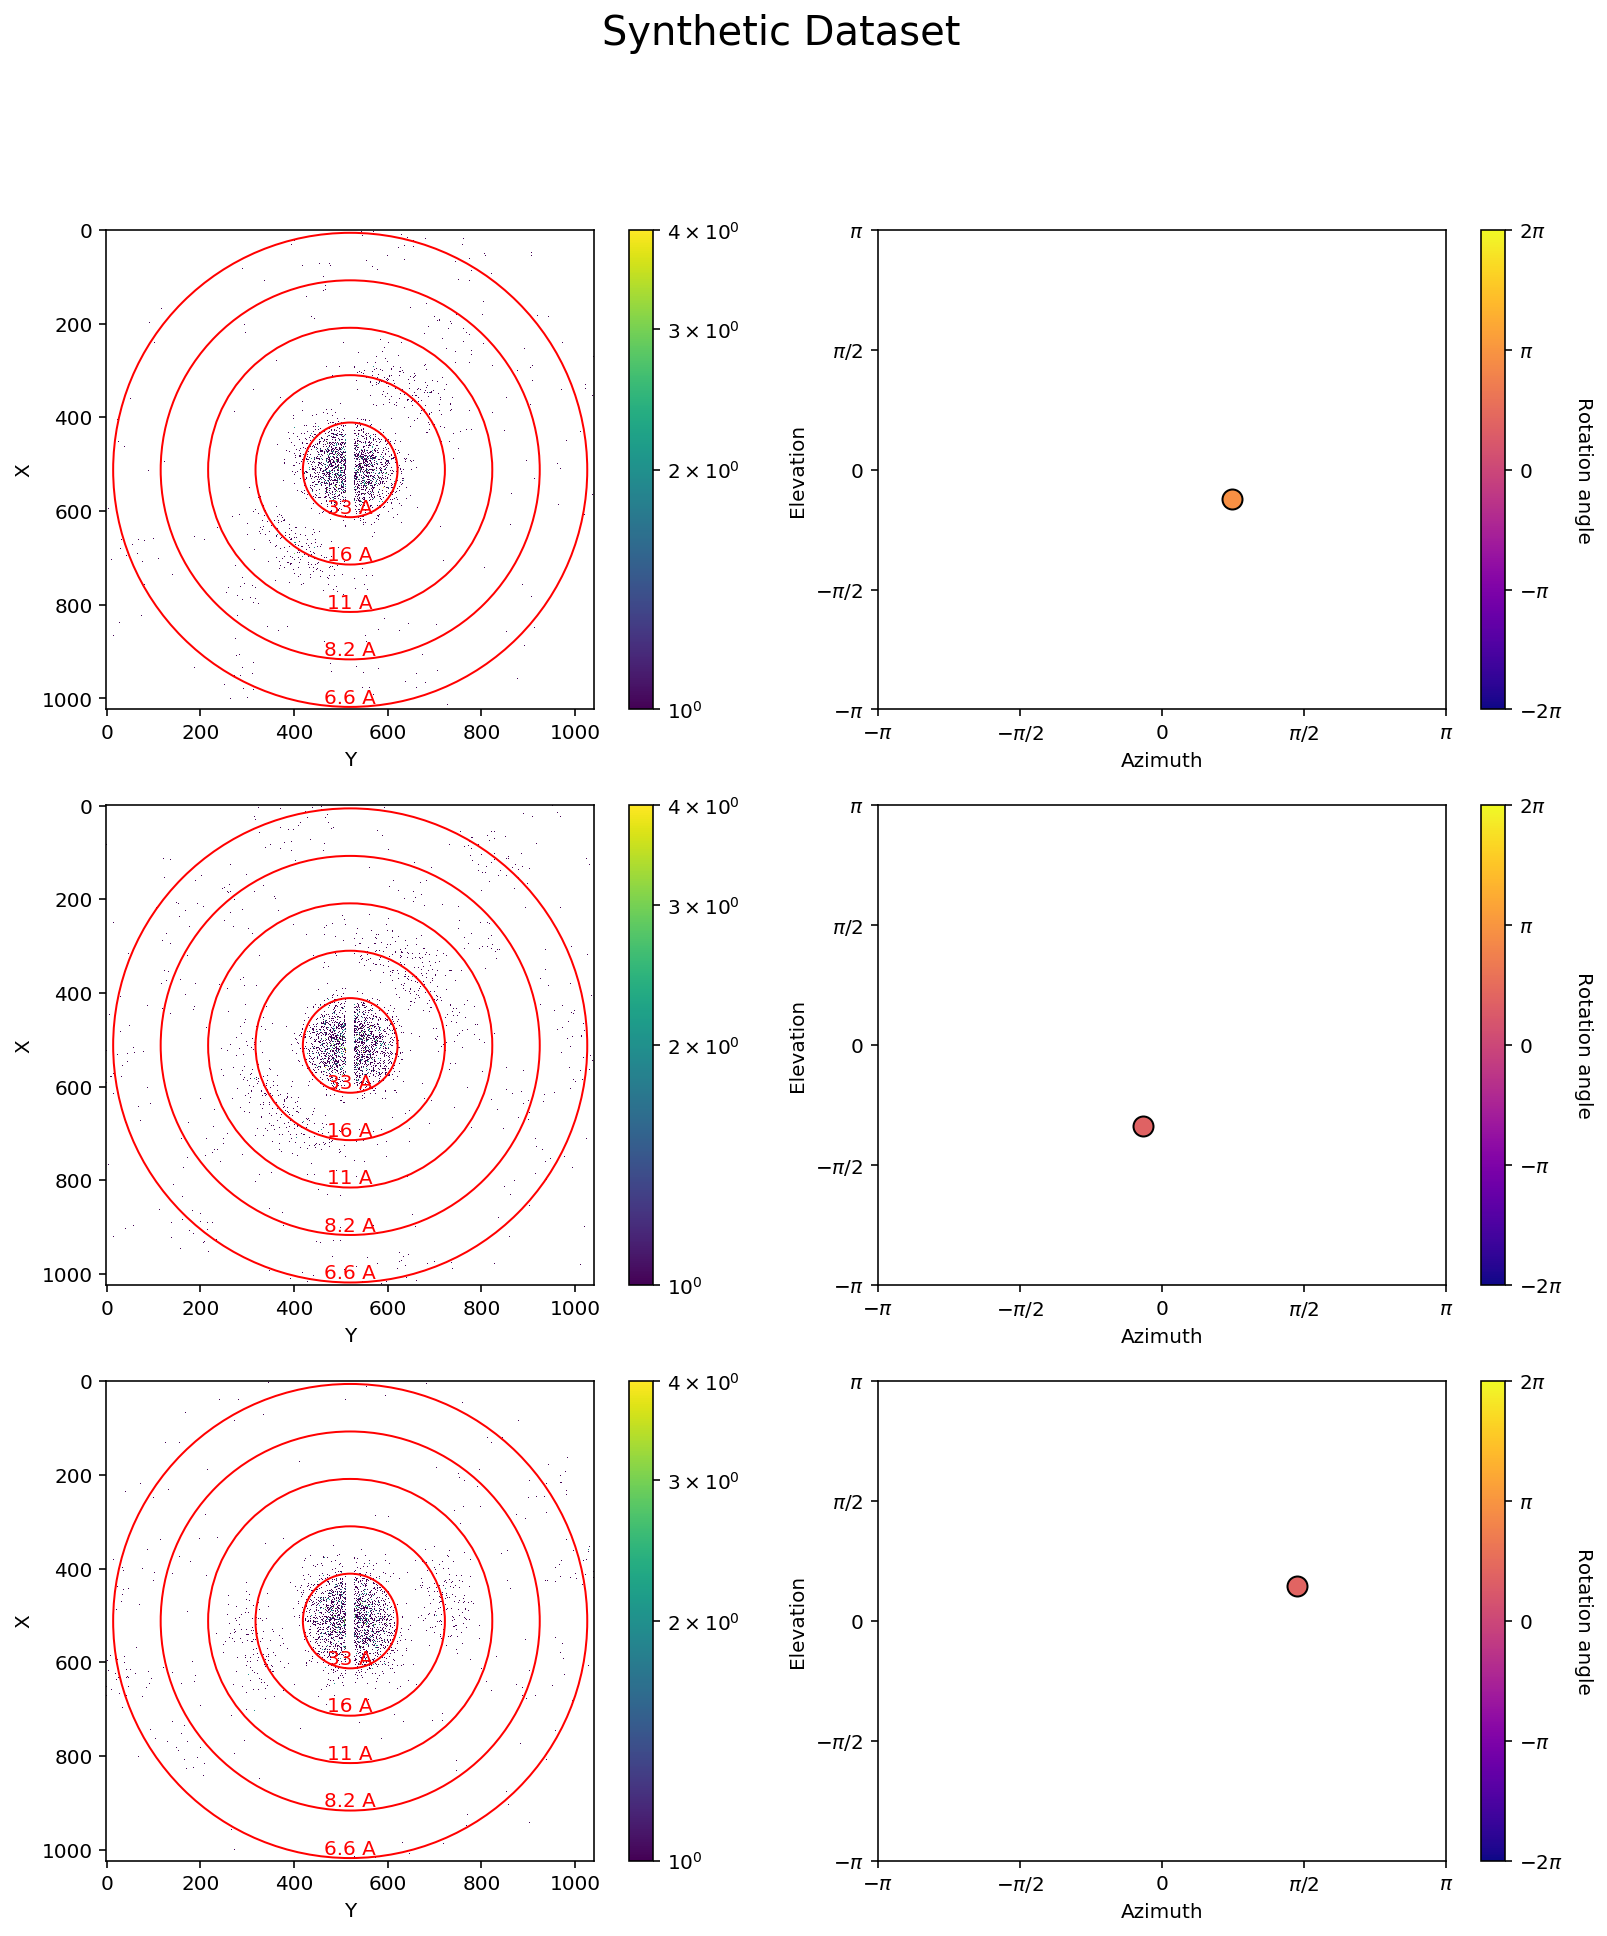

In [5]:
def angle_axis_representation(quaternion):
    q_r = quaternion[0]
    q_ijk = quaternion[1:]
    # https://en.wikipedia.org/wiki/Quaternions_and_spatial_rotation
    q_norm = np.linalg.norm(q_ijk)
    axis = q_ijk / q_norm
    theta = 2 * np.arctan2(q_norm, q_r)
    return axis, theta

def azimuth_elevation_representation(unit_vector):
    x = unit_vector[0]
    y = unit_vector[1]
    z = unit_vector[2]
    # https://en.wikipedia.org/wiki/Spherical_coordinate_system
    azimuth = np.arctan2(y, x)
    elevation = np.arctan2(z, np.sqrt(x ** 2 + y ** 2))
    return azimuth, elevation

def plot_orientation(ax, azimuth, elevation, theta, cmap=cm.plasma):
    norm = Normalize(vmin=-2*np.pi, vmax=2*np.pi)
    color = cmap(norm(theta))
    
    scatter = ax.scatter(azimuth, elevation, color=color, s=100, edgecolors='black')
        
    ax.set_xlabel('Azimuth')
    ax.set_ylabel('Elevation')
    
    ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
    ax.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
    
    ax.set_xticklabels(['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$'])
    ax.set_yticklabels(['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$'])
    
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ticks=[-2*np.pi, -np.pi, 0, np.pi, 2*np.pi])
    cbar.set_label('Rotation angle', rotation=270, labelpad=15)
    cbar.ax.set_yticklabels(['$-2\pi$', '$-\pi$', '0', '$\pi$', '$2\pi$'])  # vertically oriented colorbar

fig_nrows = 3
fig_ncols = 2

fig_width = 14
fig_height = 5 * fig_nrows

plt.figure(figsize=(fig_width, fig_height))
viz = ps.Visualizer(experiment, diffraction_rings="auto", log_scale=True)

for diffraction_pattern_idx, diffraction_pattern in enumerate(diffraction_patterns[:fig_nrows]):
    plt.subplot(fig_nrows, fig_ncols, 2 * (diffraction_pattern_idx + 1) - 1)
    viz.imshow(diffraction_pattern)
    
    orientation = orientations[diffraction_pattern_idx]
    axis, theta = angle_axis_representation(orientation)
    azimuth, elevation = azimuth_elevation_representation(axis)
    
    ax = plt.subplot(fig_nrows, fig_ncols, 2 * (diffraction_pattern_idx + 1))  
    plot_orientation(ax, azimuth, elevation, theta)

plt.suptitle('Synthetic Dataset', fontsize=20)
plt.show()

We will lastly save the diffraction patterns and orientations collected from the experiment to an HDF5 file.

../output/cspi_synthetic_dataset_diffraction_patterns_1024x1040.hdf5
[u'diffraction_patterns', u'orientations']
<HDF5 dataset "diffraction_patterns": shape (100, 1024, 1040), type "<f4">
<HDF5 dataset "orientations": shape (100, 4), type "<f4">




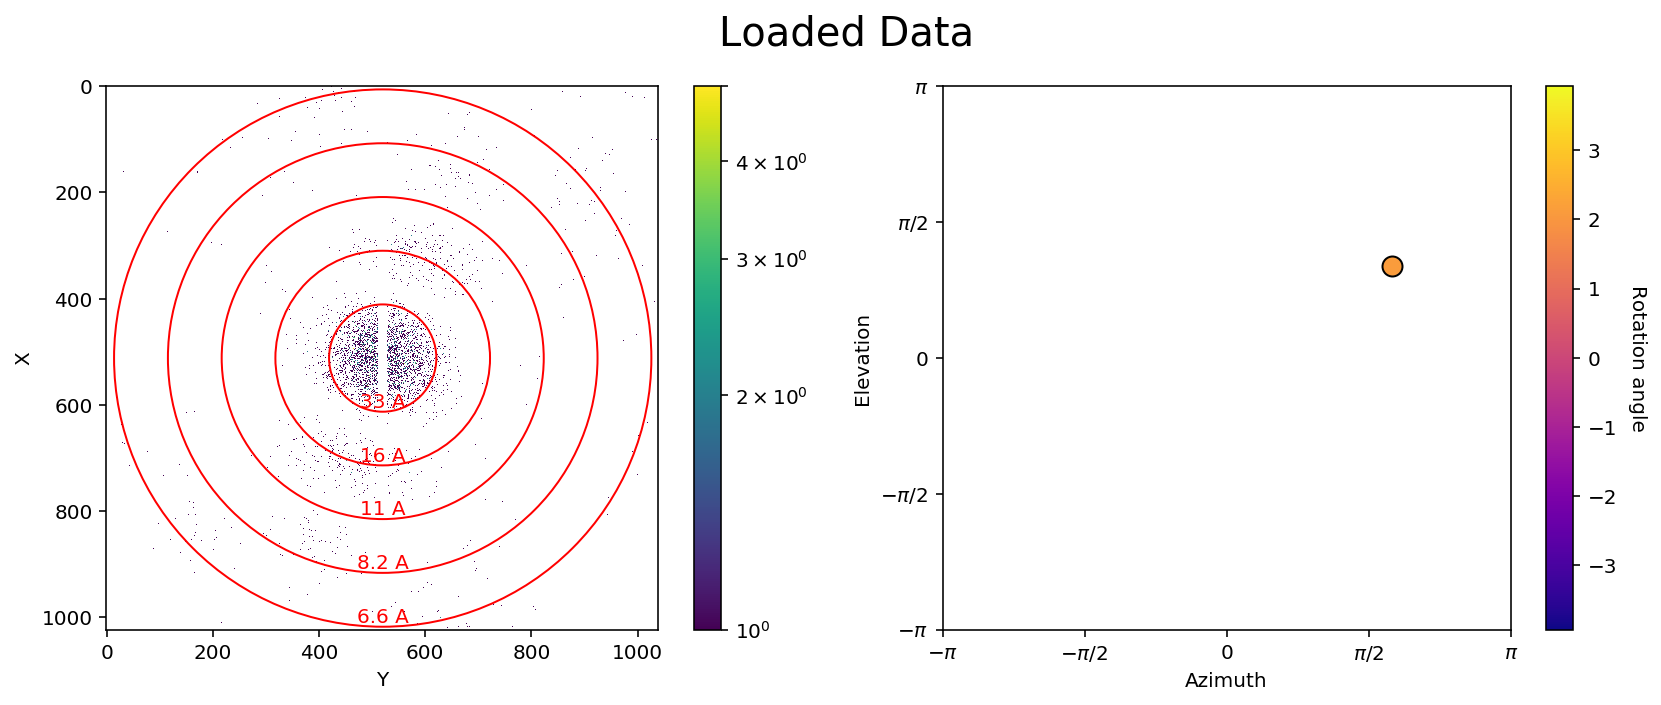

In [6]:
output_dir = '../output'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

cspi_synthetic_dataset_file = os.path.join(output_dir, 'cspi_synthetic_dataset_diffraction_patterns_{}x{}.hdf5'.format(diffraction_patterns.shape[1], diffraction_patterns.shape[2]))
print(cspi_synthetic_dataset_file)

diffraction_patterns_dataset_name = "diffraction_patterns"
orientations_dataset_name = "orientations"

with h5.File(cspi_synthetic_dataset_file, "w") as cspi_synthetic_dataset_file_handle:
    dset_diffraction_patterns = cspi_synthetic_dataset_file_handle.create_dataset(diffraction_patterns_dataset_name, diffraction_patterns.shape, dtype='f')
    dset_diffraction_patterns[...] = diffraction_patterns
    dset_orientations = cspi_synthetic_dataset_file_handle.create_dataset(orientations_dataset_name, orientations.shape, dtype='f')
    dset_orientations[...] = orientations

with h5.File(cspi_synthetic_dataset_file, "r") as cspi_synthetic_dataset_file_handle:
    print(list(cspi_synthetic_dataset_file_handle.keys()))
    print(cspi_synthetic_dataset_file_handle[diffraction_patterns_dataset_name])
    print(cspi_synthetic_dataset_file_handle[orientations_dataset_name])
    
    loaded_diffraction_pattern = cspi_synthetic_dataset_file_handle[diffraction_patterns_dataset_name][0]
    loaded_orientation = cspi_synthetic_dataset_file_handle[orientations_dataset_name][0]

print('\n')
    
fig_nrows = 1
fig_ncols = 2

fig_width = 14
fig_height = 5 * fig_nrows

plt.figure(figsize=(fig_width, fig_height))
viz = ps.Visualizer(experiment, diffraction_rings="auto", log_scale=True)

plt.subplot(fig_nrows, fig_ncols, 1)
viz.imshow(loaded_diffraction_pattern)

axis, theta = angle_axis_representation(loaded_orientation)
azimuth, elevation = azimuth_elevation_representation(axis)

ax = plt.subplot(fig_nrows, fig_ncols, 2)  
plot_orientation(ax, azimuth, elevation, theta)

plt.suptitle('Loaded Data', fontsize=20)
plt.show()